# **Data Modelling and Evaluation**

---

## Objectives

* Answer business requirement 2: 
    * The client seeks to predict whether a cherry leaf is healthy or infected with powdery mildew.

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/test
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file





## Additional Comments:

N/A


---

## 1. Set Data Directory and Import Libraries

---

Import libraries

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model


---

## 2. Set working directory

---

In [5]:
cwd= os.getcwd()

In [6]:
os.chdir('/workspace/Portfolio_5_Cherry_Leaves_Mildew')
print("You set a new current directory")

You set a new current directory


In [7]:
work_dir = os.getcwd()
work_dir

'/workspace/Portfolio_5_Cherry_Leaves_Mildew'

---

## 3. Set input directories (Train, Validation, Test)

---

Set train, validation and test paths.

In [8]:
base_dir = '/workspace/Portfolio_5_Cherry_Leaves_Mildew/inputs/cherry_leaves_dataset/cherry-leaves'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


---

## 4. Set output directory

---

In [9]:

version = 'v1'
base_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'  # Make sure to set your base directory
file_path = os.path.join(base_dir, 'outputs', version)

# Function to automatically increment version
def increment_version(ver):
    base, num = ver[:-1], int(ver[-1])  # Assumes version format is vX where X is a digit
    return f"{base}{num + 1}"

# Check if 'outputs' directory exists, if not, create it
if 'outputs' not in os.listdir(base_dir):
    os.makedirs(os.path.join(base_dir, 'outputs'))

# Check if the specific version exists
if version in os.listdir(os.path.join(base_dir, 'outputs')):
    print('Old version is already available. Creating a new version...')
    # Increment the version until a new, unused version is found
    while version in os.listdir(os.path.join(base_dir, 'outputs')):
        version = increment_version(version)
    # Create a new version directory
    new_file_path = os.path.join(base_dir, 'outputs', version)
    os.makedirs(new_file_path)
    print(f"New version created: {version}")
else:
    # If the version doesn't exist, create the specified version directory
    os.makedirs(file_path)
    print(f"Version {version} created.")



Old version is already available. Creating a new version...
New version created: v12


---

## 5. Set label names

---

Set labels

In [10]:
labels = os.listdir(train_dir)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

## 6. Set image shape

---

Import saved image shape embedding

In [11]:
import joblib

version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(50, 50)

---

## 7. Load Images from Train, Test, and Validation Sets

---

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)  # Note that validation data should not be augmented!

In [13]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(50, 50),
        batch_size=20,
        class_mode='binary')

test_generator.class_indices

Found 634 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [14]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(50, 50),
        batch_size=20,
        class_mode='binary')

train_generator.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [15]:
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(50, 50),
        batch_size=20,
        class_mode='binary')

validation_generator.class_indices

Found 630 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

---

## 8. Image Data Augmentation

---

Import ImageDataGenerator

* Intiatize ImageDataGenerator

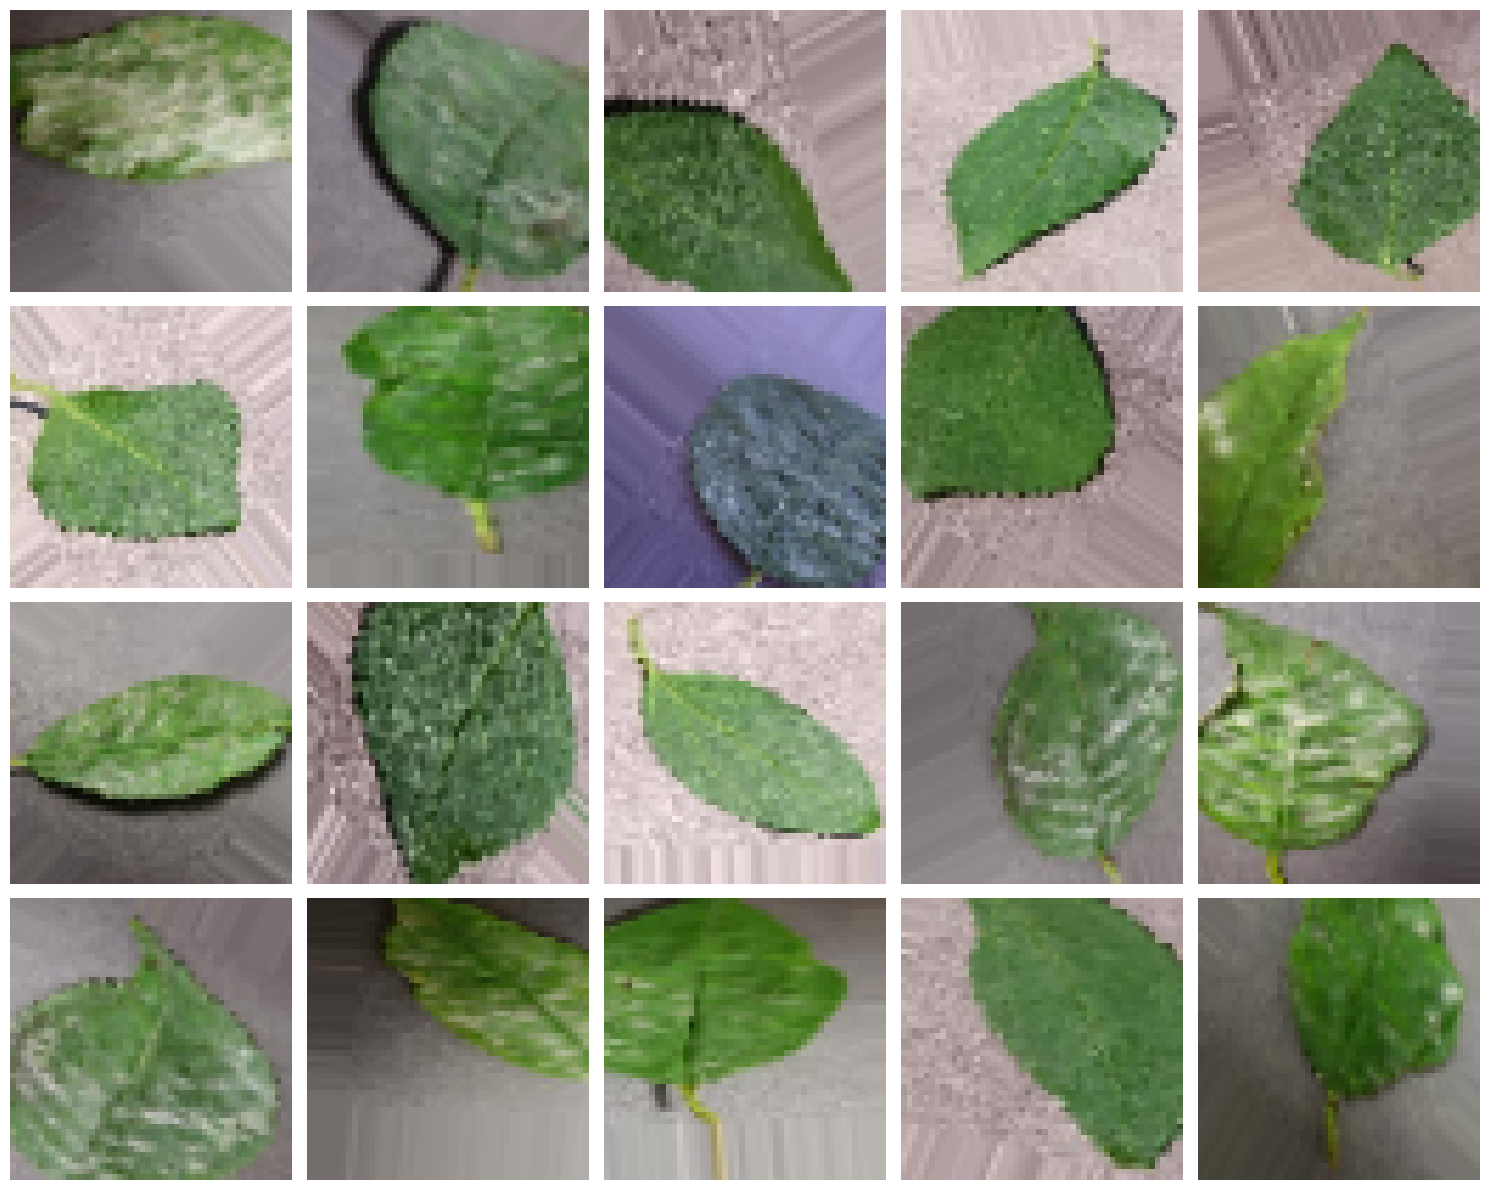

In [16]:
def plot_augmented_images(image_gen, num_images=20):
    """
    Plots a grid of `num_images` from an image generator.
    
    :param image_gen: The image generator object.
    :param num_images: The number of images to plot.
    """
    images, _ = next(image_gen)  # Get a batch of images and labels
    
    # Calculate grid size and create a new figure
    n_cols = 5  # Number of columns in the grid
    n_rows = num_images // n_cols + (num_images % n_cols > 0)  # Calculate required rows
    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    
    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i])  # Images are already rescaled by the generator
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot augmented train images
plot_augmented_images(train_generator, num_images=20)


* Augment test image dataset

In [17]:
def plot_test_images(directory_iterator, num_images=10):
    """
    Plots a specified number of test images from a DirectoryIterator.
    
    :param directory_iterator: A DirectoryIterator yielding batches of images and labels.
    :param num_images: The number of test images to plot.
    """
    # Get a batch of images and labels using next()
    images, _ = next(directory_iterator)
    
    # Determine the grid size for plotting
    n_cols = min(num_images, 5)  # Adjust the number of columns as needed, maxing out at 5
    n_rows = num_images // n_cols + (num_images % n_cols > 0)
    
    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    
    for i in range(min(num_images, len(images))):  # Ensure we do not exceed the batch size or num_images
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


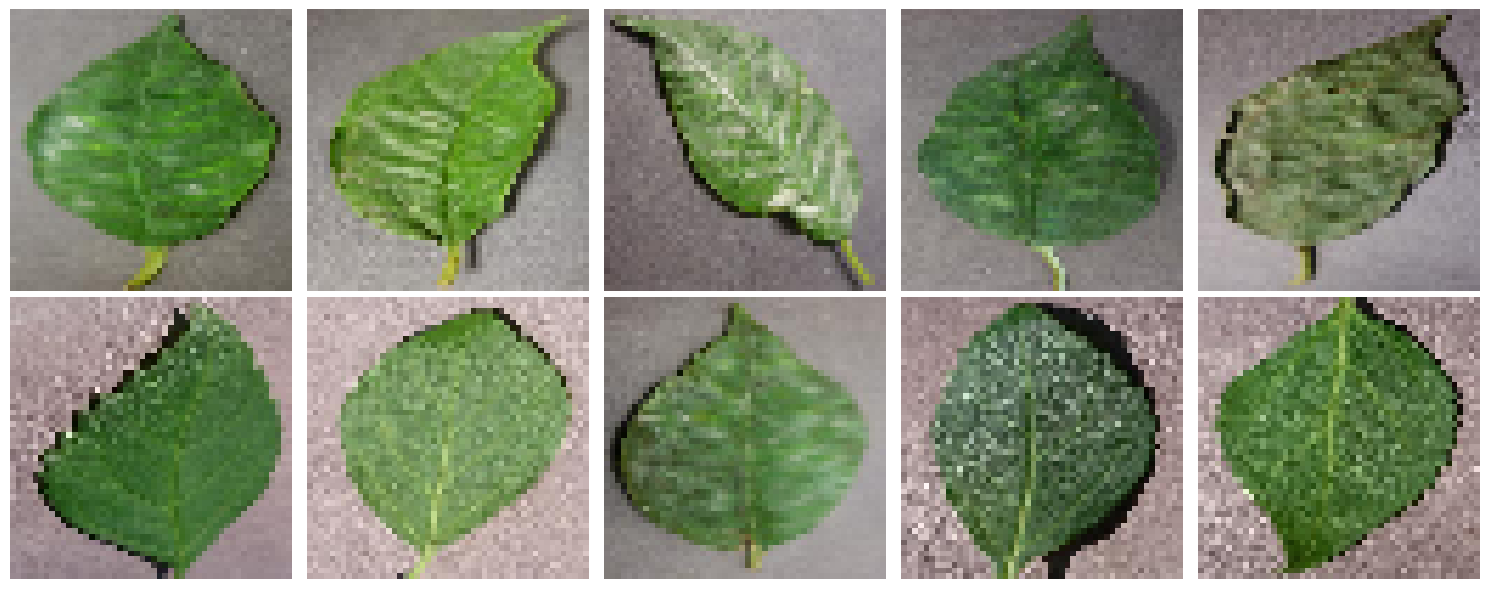

In [18]:
# Assuming test_generator is your DirectoryIterator instance
plot_test_images(test_generator, num_images=10)


* Augment train image dataset

In [19]:

def plot_train_images(generator, num_images=8):
    """
    Plots a batch of images from the given generator.
    
    :param generator: The generator yielding batches of images and labels.
    :param num_images: The number of images to plot from a single batch.
    """
    images, labels = next(generator)  # Get a batch of images and labels

    n_cols = min(num_images, 4)  # Number of columns in the plot
    n_rows = num_images // n_cols + int(num_images % n_cols != 0)  # Calculate required number of rows

    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


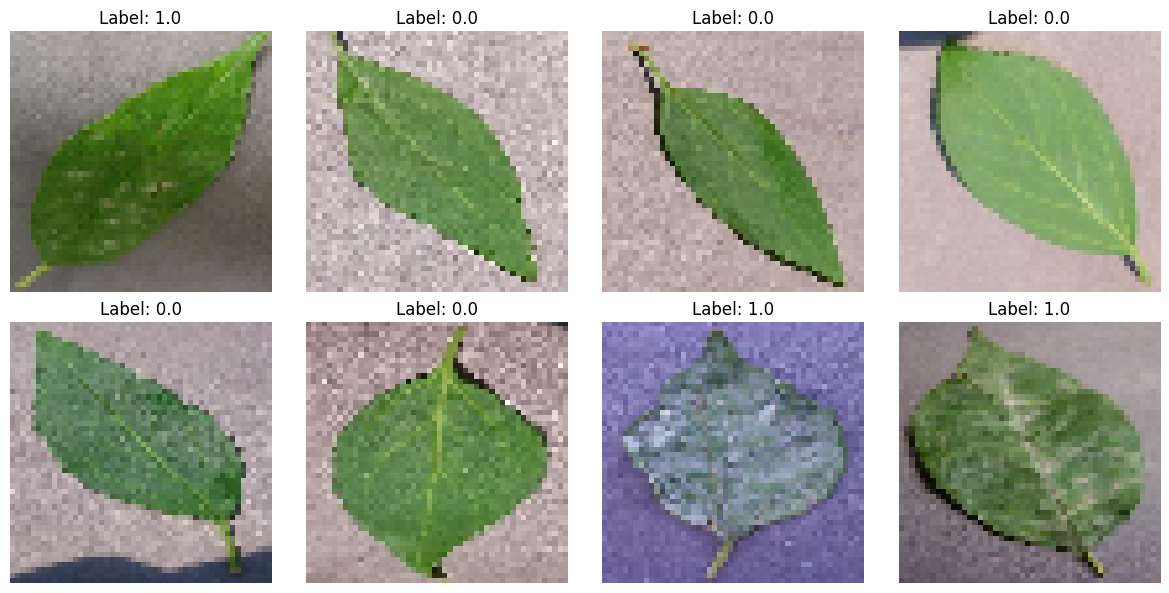

In [20]:
plot_train_images(validation_generator, num_images=8)


* Augment validation image dataset

In [21]:
def plot_validation_images(generator, num_images=8):
    """
    Plots a batch of images from the given generator.
    
    :param generator: The generator yielding batches of images and labels.
    :param num_images: The number of images to plot from a single batch.
    """
    images, labels = next(generator)  # Get a batch of images and labels

    n_cols = min(num_images, 4)  # Number of columns in the plot
    n_rows = num_images // n_cols + int(num_images % n_cols != 0)  # Calculate required number of rows

    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


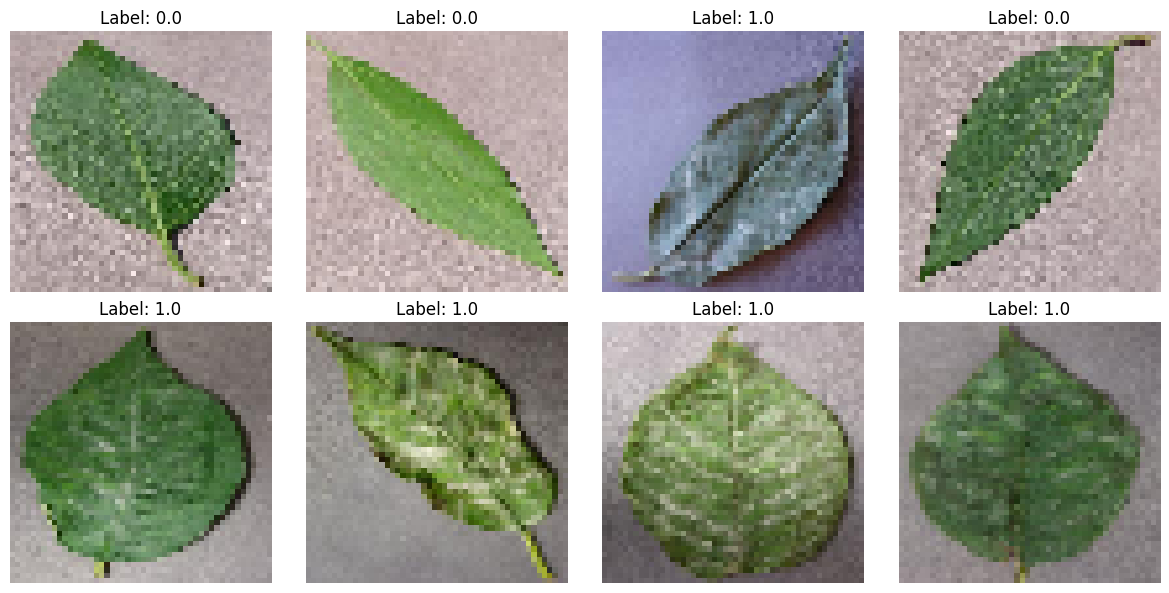

In [22]:
plot_validation_images(validation_generator, num_images=8)


---

## 9. Save Class Indices

---

In [23]:
class_indices = {'healthy': 0, 'powdery_mildew': 1} 

# Save the class indices to a file using joblib or any other suitable method
joblib.dump(class_indices, f'{file_path}/class_indices.pkl')

['inputs/cherry_leaves_dataset/cherry-leaves/outputs/v1/class_indices.pkl']

---

## 10. Model Creation and Training

---

Advanced model and hyperparameter tuning using GridSearchCV


* Prepare Data

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Initialize the model with the correct input shape
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),  # Updated input shape
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

* Define a callback function in Keras that monitors the model's accuracy and stops training once the accuracy reaches 97% (or any other threshold)

In [25]:
from tensorflow.keras.callbacks import Callback

class AccuracyThresholdCallback(Callback):
    """
    Custom callback to stop training when a specified accuracy threshold is reached.
    """
    def __init__(self, threshold, min_epochs):
        super(AccuracyThresholdCallback, self).__init__()
        self.threshold = threshold
        self.min_epochs = min_epochs

    def on_epoch_end(self, epoch, logs=None):
        # Check if the accuracy threshold has been reached
        if epoch >= self.min_epochs - 1:  # epochs are zero-indexed
            if logs.get('accuracy') is not None and logs.get('accuracy') >= self.threshold:
                print(f"\nEpoch {epoch+1}: Reached {self.threshold * 100}% accuracy. Stopping training.")
                self.model.stop_training = True

# Instantiate the callback with your desired threshold
accuracy_threshold_callback = AccuracyThresholdCallback(threshold=0.99, min_epochs=5)

* Fit model for model training

In [26]:
from tensorflow.keras.callbacks import Callback

class DetailedHistory(Callback):
    def on_train_batch_end(self, batch, logs=None):
        # Log training metrics more frequently (e.g., every 10 batches)
        if batch % 10 == 0:
            print(f"Batch {batch}: Loss = {logs['loss']}, Accuracy = {logs['accuracy']}")

    def on_epoch_end(self, epoch, logs=None):
        # Log validation metrics at the end of each epoch
        print(f"Epoch {epoch}: Val Loss = {logs['val_loss']}, Val Accuracy = {logs['val_accuracy']}")

detailed_history = DetailedHistory()

In [28]:
history = model.fit(
    train_generator,
    epochs=25,
    steps_per_epoch=len(train_generator.classes) // 20,
    validation_data=validation_generator,  # Make sure this is provided
    validation_steps=len(validation_generator.classes) // 20,
    callbacks=[detailed_history, accuracy_threshold_callback],
    verbose=1
)

Epoch 1/25


Batch 0: Loss = 0.6874412298202515, Accuracy = 0.6499999761581421
147/147 [==============================] - 9s 52ms/step - loss: 0.4768 - accuracy: 0.7456 - val_loss: 0.1856 - val_accuracy: 0.9210
Epoch 2/25
Batch 0: Loss = 0.3582349717617035, Accuracy = 0.8999999761581421
147/147 [==============================] - 5s 36ms/step - loss: 0.2314 - accuracy: 0.9104 - val_loss: 0.2426 - val_accuracy: 0.8984
Epoch 3/25
Batch 0: Loss = 0.11494338512420654, Accuracy = 0.949999988079071
147/147 [==============================] - 5s 35ms/step - loss: 0.1290 - accuracy: 0.9542 - val_loss: 0.1051 - val_accuracy: 0.9629
Epoch 4/25
Batch 0: Loss = 0.02676893211901188, Accuracy = 1.0
147/147 [==============================] - 5s 35ms/step - loss: 0.0985 - accuracy: 0.9679 - val_loss: 0.1107 - val_accuracy: 0.9661
Epoch 5/25
Batch 0: Loss = 0.14237891137599945, Accuracy = 0.949999988079071
147/147 [==============================] - 6s 40ms/step - loss: 0.0920 - accuracy: 0.9709 - val_loss: 0.0586 - v

* Save model


In [29]:
model.save('outputs/v1/malaria_detector_model.h5')

/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---

## 11. Model Performace

---

### Model learning curve

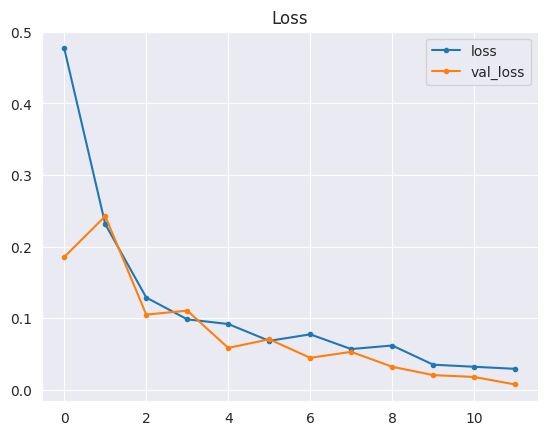

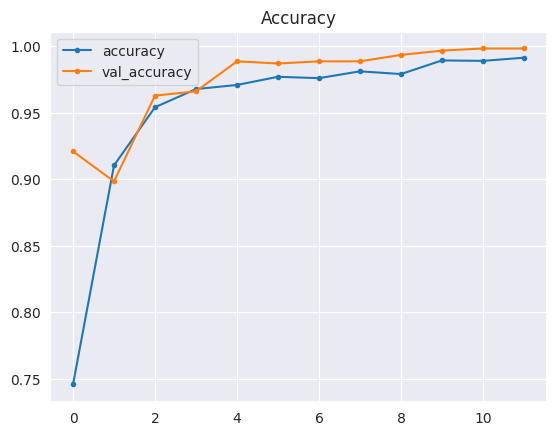

In [30]:
loss = pd.DataFrame(model.history.history)
sns.set_style("darkgrid")

# Plot only if 'val_loss' is present
if 'val_loss' in loss.columns:
    loss[['loss', 'val_loss']].plot(style='.-')
    plt.title("Loss")
    plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
    plt.show()

if 'val_accuracy' in loss.columns:
    loss[['accuracy', 'val_accuracy']].plot(style='.-')
    plt.title("Accuracy")
    plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
    plt.show()


### Model Evaluation on Test Data

* Load saved model

In [31]:
from keras.models import load_model
model = load_model('outputs/v1/malaria_detector_model.h5')

* Evaluate model on test set

In [32]:
evaluation = model.evaluate(test_generator)

 6/32 [====>.........................] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000    

32/32 [==============================] - 1s 15ms/step - loss: 0.0052 - accuracy: 0.9968


* Save evaluation pickle

In [33]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

### Prediction on a Random Image File

* Load a random image as PIL

In [34]:
import random
from tensorflow.keras.preprocessing import image

# Select a random label from the 'labels' list
random_label = random.choice(labels)

# Construct the path for the chosen label
label_dir = os.path.join(test_dir, random_label)

# Get a list of all files in the chosen label directory
files_in_label_dir = os.listdir(label_dir)

# Select a random file from the list of files
random_file = random.choice(files_in_label_dir)

# Construct the full path for the randomly selected image
image_path = os.path.join(label_dir, random_file)

# Load the image
pil_image = image.load_img(image_path, target_size=image_shape, color_mode='rgb')

print(f'Randomly selected label: {random_label}')
print(f'Image path: {image_path}')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')



Randomly selected label: powdery_mildew
Image path: /workspace/Portfolio_5_Cherry_Leaves_Mildew/inputs/cherry_leaves_dataset/cherry-leaves/test/powdery_mildew/6c2861d5-bc13-4296-aa71-1225c3bad7df___FREC_Pwd.M 4804.JPG
Image shape: (50, 50), Image mode: RGB


* Display the image

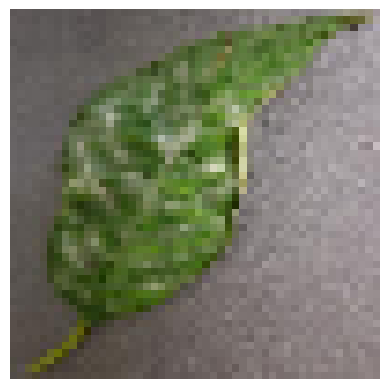

In [35]:
import matplotlib.pyplot as plt

plt.imshow(pil_image)
plt.axis('off')
plt.show()

* Convert image to array and prepare for prediction

In [36]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 50, 50, 3)


* Predict class probabilities

In [37]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_generator.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 [==============================] - 0s 77ms/step
0.9999991
powdery_mildew


----

## 12. Conlusions

---

- **Effective Performance**: The model showcases impressive performance, even with a relatively small dataset, highlighting its efficiency in learning from limited data.

- **Consistent Learning**: Analysis of loss and accuracy curves reveals a stable and consistent training behavior, with no signs of overfitting or underfitting, indicating a well-tuned model.

- **Accurate Predictions**: Demonstrates a strong capability to accurately predict the class of new, unseen images, confirming the model's generalization ability.

- **Data Augmentation Impact**: The application of data augmentation techniques significantly contributed to the model's robustness, allowing it to handle a variety of image orientations and scales.

- **Real-World Applicability**: The model's reliability in classifying cherry leaf diseases underlines its potential for real-world agricultural applications, offering valuable support for early disease detection and management.

- **Future Improvement Avenues**: While current results are promising, exploring more complex architectures, deeper networks, and larger datasets could further enhance model performance and reliability.

---

## 13. Push Files to Repo (Git Commands)

---

#### Push generated/new files from this Session to GitHub repo

* .gitignore

In [438]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

* Git status

In [439]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   inputs/cherry_leaves_dataset/cherry-leaves/outputs/v1/model_training_acc.png
	modified:   inputs/cherry_leaves_dataset/cherry-leaves/outputs/v1/model_training_losses.png
	modified:   outputs/v1/evaluation.pkl
	modified:   outputs/v1/malaria_detector_model.h5

no changes added to commit (use "git add" and/or "git commit -a")


* Git add

In [440]:
!git add .

* Git commit

In [441]:
!git commit -am " Add new plots- test run"

[main a7b888f]  Add new plots- test run
 4 files changed, 0 insertions(+), 0 deletions(-)


* Git Push

In [442]:
!git push

Enumerating objects: 25, done.
Counting objects: 100% (25/25), done.
Delta compression using up to 16 threads
Compressing objects: 100% (9/9), done.
Writing objects: 100% (13/13), 3.59 MiB | 8.08 MiB/s, done.
Total 13 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/adamolnar/Portfolio_5_Cherry_Leaves_Mildew.git
   9d4fdbf..a7b888f  main -> main
